<a href="https://colab.research.google.com/github/Vurimindi2021/Capstone3/blob/main/src/translated/nlp_contradictory_Distilbert_Base_uncased_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install googletrans==3.1.0a0
!pip install dask[Bag]

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 895 kB 77.6 MB/s 
     |████████████████████████████████| 636 kB 77.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.9 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 10.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=692670a0d541f50091645c279e77b8f6656ce6b86ee4fdeaac6e445f1a9052ce
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully

In [ ]:
## importing packages
import gc
import os
import random
import transformers
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from googletrans import Translator
from pathlib import Path
from os import path, walk
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
warnings.filterwarnings("ignore")

In [ ]:
## defining configuration
class Configuration():
    """
    All configuration for running an experiment
    """
    def __init__(
        self,
        model_name,
        save_model,
        translation = False,
        max_length = 64,
        padding = True,
        batch_size = 128,
        epochs = 5,
        learning_rate = 1e-5,
        metrics = ["sparse_categorical_accuracy"],
        verbose = 1,
        train_splits = 5,
        accelerator = "TPU",
        myluckynumber = 13
    ):
        # seed and accelerator
        self.SEED = myluckynumber
        self.ACCELERATOR = accelerator

        # paths
        self.PATH_TRAIN = Path("/content/drive/MyDrive/nlp/data/translated/english_transled_train.csv")
        self.PATH_TEST  = Path("/content/drive/MyDrive/nlp/data/translated/english_transled_test.csv")
        self.CHEK_PATH  = os.path.join("/content/drive/MyDrive/nlp/check_point/translated",save_model)

        # splits
        self.TRAIN_SPLITS = train_splits

        # mapping of language
        self.LANGUAGE_MAP = {
            "English"   : 0,
            "Chinese"   : 1,
            "Arabic"    : 2,
            "French"    : 3,
            "Swahili"   : 4,
            "Urdu"      : 5,
            "Vietnamese": 6,
            "Russian"   : 7,
            "Hindi"     : 8,
            "Greek"     : 9,
            "Thai"      : 10,
            "Spanish"   : 11,
            "German"    : 12,
            "Turkish"   : 13,
            "Bulgarian" : 14
        }

        self.INVERSE_LANGUAGE_MAP = {v: k for k, v in self.LANGUAGE_MAP.items()}

        # model configuration
        self.MODEL_NAME = model_name
        self.TRANSLATION = translation
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_NAME)

        # model hyperparameters
        self.MAX_LENGTH = max_length
        self.PAD_TO_MAX_LENGTH = padding
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.LEARNING_RATE = learning_rate
        self.METRICS = metrics
        self.VERBOSE = verbose
        
        # initializing accelerator
        self.initialize_accelerator()

    def initialize_accelerator(self):
        """
        Initializing accelerator
        """
        # checking TPU first
        if self.ACCELERATOR == "TPU":
            print("Connecting to TPU")
            try:
                tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
                print(f"Running on TPU {tpu.master()}")
            except ValueError:
                print("Could not connect to TPU")
                tpu = None

            if tpu:
                try:
                    print("Initializing TPU")
                    tf.config.experimental_connect_to_cluster(tpu)
                    tf.tpu.experimental.initialize_tpu_system(tpu)
                    self.strategy = tf.distribute.TPUStrategy(tpu)
                    self.tpu = tpu
                    print("TPU initialized")
                except _:
                    print("Failed to initialize TPU")
            else:
                print("Unable to initialize TPU")
                self.ACCELERATOR = "GPU"

        # default for CPU and GPU
        if self.ACCELERATOR != "TPU":
            print("Using default strategy for CPU and single GPU")
            self.strategy = tf.distribute.get_strategy()

        # checking GPUs
        if self.ACCELERATOR == "GPU":
            print(f"GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

        # defining replicas
        self.AUTO = tf.data.experimental.AUTOTUNE
        self.REPLICAS = self.strategy.num_replicas_in_sync
        print(f"REPLICAS: {self.REPLICAS}")

In [ ]:
## data preparation functions
def translate_text_to_english(text):
    """
    Translates text to English.
    """
    translator = Translator()

    return translator.translate(text, dest = "en").text

def encode_text(df, tokenizer, max_len, padding):
    """
    Preprocessing textual data into encoded tokens.
    """
    text = df[["premise", "hypothesis"]].values.tolist()

    # encoding text using tokenizer of the model
    text_encoded = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length = padding,
        max_length = max_len,
        truncation = True
    )

    return text_encoded

In [ ]:
def get_tf_dataset(X, y, auto, labelled = True, repeat = False, shuffle = False, batch_size = 128):
    """
    Creating tf.data.Dataset for TPU.
    """
    if labelled:
        ds = (tf.data.Dataset.from_tensor_slices((X["input_ids"], y)))
    else:
        ds = (tf.data.Dataset.from_tensor_slices(X["input_ids"]))

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(auto)

    return ds

In [ ]:
## building model
def build_model(model_name, max_len, learning_rate, metrics):
    """
    Building the Deep Learning architecture
    """
    # defining encoded inputs
    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    
    # defining transformer model embeddings
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_embeddings = transformer_model(input_ids)[0]

    # defining output layer
    output_values = Dense(3, activation = "softmax")(transformer_embeddings[:, 0, :])

    # defining model
    model = Model(inputs = input_ids, outputs = output_values)
    opt = Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = metrics

    model.compile(optimizer = opt, loss = loss, metrics = metrics)
    return model

In [ ]:
## stratified k-fold over language and label
def run_model(config):
    """
    Running the model
    """
    ## reading data
    df_train = pd.read_csv(config.PATH_TRAIN)
    print(df_train.iloc[18344])
    df_train.drop(18344, axis=0, inplace=True)
    df_test = pd.read_csv(config.PATH_TEST)
    
    # translating non-English text to English
    if config.TRANSLATION:
        df_train.loc[df_train.language != "English", "premise"] = df_train[df_train.language != "English"].premise.apply(lambda x: translate_text_to_english(x))
        print("Translating of Train premise completed")
        df_test.loc[df_test.language != "English", "premise"] = df_test[df_test.language != "English"].premise.apply(lambda x: translate_text_to_english(x))
        print("Translating of Test premise completed")
        df_train.loc[df_train.language != "English", "hypothesis"] = df_train[df_train.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))
        print("Translating of Train hypothesis completed")
        df_test.loc[df_test.language != "English", "hypothesis"] = df_test[df_test.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))
        print("Translating of Test hypothesis completed")
    # adding column for stratified splitting
    df_train["language_label"] = df_train.language.astype(str) + "_" + df_train.label.astype(str)
    print("adding column for stratified splitting")

    # stratified K-fold on language and label
    skf = StratifiedKFold(n_splits = config.TRAIN_SPLITS, shuffle = True, random_state = config.SEED)
    print("stratified K-fold on language and label")

    # initializing predictions
    preds_oof = np.zeros((df_train.shape[0], 3))
    preds_test = np.zeros((df_test.shape[0], 3))
    acc_oof = []

    # iterating over folds
    for (fold, (train_index, valid_index)) in enumerate(skf.split(df_train, df_train.language_label)):
        # initializing TPU
        if config.ACCELERATOR == "TPU":
            if config.tpu:
                config.initialize_accelerator()

        # building model
        K.clear_session()
        with config.strategy.scope():
            model = build_model(config.MODEL_NAME, config.MAX_LENGTH, config.LEARNING_RATE, config.METRICS)
            if fold == 0:
                print(model.summary())

        print("\n")
        print("#" * 19)
        print(f"##### Fold: {fold + 1} #####")
        print("#" * 19)

        # splitting data into training and validation
        X_train = df_train.iloc[train_index]
        X_valid = df_train.iloc[valid_index]

        y_train = X_train.label.values
        y_valid = X_valid.label.values

        print("\nTokenizing")

        # encoding text data using tokenizer
        X_train_encoded = encode_text(df = X_train, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)
        X_valid_encoded = encode_text(df = X_valid, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # creating TF Dataset
        ds_train = get_tf_dataset(X_train_encoded, y_train, config.AUTO, repeat = True, shuffle = True, batch_size = config.BATCH_SIZE * config.REPLICAS)
        ds_valid = get_tf_dataset(X_valid_encoded, y_valid, config.AUTO, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        n_train = X_train.shape[0]

        if fold == 0:
            X_test_encoded = encode_text(df = df_test, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # saving model at best accuracy epoch

        sv = tf.keras.callbacks.ModelCheckpoint(
            config.CHEK_PATH,
            monitor = "val_sparse_categorical_accuracy",
            verbose = 0,
            save_best_only = True,
            save_weights_only = True,
            mode = "max",
            save_freq = "epoch"
        )
        print("\nTraining")

        # training model
        model_history = model.fit(
            ds_train,
            epochs = config.EPOCHS,
            callbacks = [sv],
            steps_per_epoch = n_train / config.BATCH_SIZE // config.REPLICAS,
            validation_data = ds_valid,
            verbose = config.VERBOSE
        )
        # list all data in history
        print(model_history.history.keys())
        # summarize history for accuracy
        plt.plot(model_history.history['sparse_categorical_accuracy'])
        plt.plot(model_history.history['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig(fname='/content/drive/MyDrive/nlp/figs/translated/distilbert_base_uncased_accuracy.png')
        plt.show()

        # Plot training & validation loss values
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig(fname='/content/drive/MyDrive/nlp/figs/translated/distilbert_base_uncased_loss.png')
        plt.show()

        print("\nValidating")

        # scoring validation data
        model.load_weights(config.CHEK_PATH)
        ds_valid = get_tf_dataset(X_valid_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        preds_valid = model.predict(ds_valid, verbose = config.VERBOSE)
        acc = accuracy_score(y_valid, np.argmax(preds_valid, axis = 1))

        preds_oof[valid_index] = preds_valid
        acc_oof.append(acc)

        print("\nInferencing")

        # scoring test data
        ds_test = get_tf_dataset(X_test_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)
        preds_test += model.predict(ds_test, verbose = config.VERBOSE) / config.TRAIN_SPLITS

        print(f"\nFold {fold + 1} Accuracy: {round(acc, 4)}\n")

        g = gc.collect()

    # overall CV score and standard deviation
    print(f"\nCV Mean Accuracy: {round(np.mean(acc_oof), 4)}")
    print(f"CV StdDev Accuracy: {round(np.std(acc_oof), 4)}\n")

    return preds_oof, preds_test

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Connecting to TPU
Running on TPU grpc://10.80.223.226:8470
Initializing TPU
INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8
Unnamed: 0                18345
id                  tef30ab26c0
premise       what is your luck
hypothesis              Try it.
lang_abv                     sw
language                swahili
label                         0
Name: 18344, dtype: object
adding column for stratified splitting
stratified K-fold on language and label
Connecting to TPU
Running on TPU grpc://10.80.223.226:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 66,365,187
Trainable params: 66,365,187
Non-trainable params: 0
_________________________________________________________________
None


###################
##### Fold: 1 #####
###################

Tokenizing

Training
Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


46/46 [==============================] - ETA: 0s - loss: 1.1043 - sparse_categorical_accuracy: 0.3429

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


46/46 [==============================] - 73s 598ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.3429 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.3466
Epoch 2/20
46/46 [==============================] - 14s 304ms/step - loss: 1.0957 - sparse_categorical_accuracy: 0.3570 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.3741
Epoch 3/20
46/46 [==============================] - 14s 317ms/step - loss: 1.0512 - sparse_categorical_accuracy: 0.4434 - val_loss: 0.9679 - val_sparse_categorical_accuracy: 0.5383
Epoch 4/20
46/46 [==============================] - 14s 307ms/step - loss: 0.9110 - sparse_categorical_accuracy: 0.5746 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.6004
Epoch 5/20
46/46 [==============================] - 14s 305ms/step - loss: 0.8159 - sparse_categorical_accuracy: 0.6343 - val_loss: 0.8478 - val_sparse_categorical_accuracy: 0.6196
Epoch 6/20
46/46 [==============================] - 14s 307ms/step - loss: 0.7371 - sparse_categorical_acc

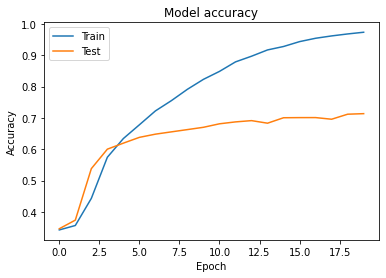

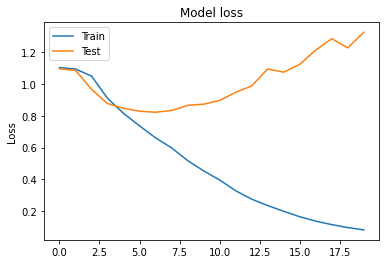


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


12/12 [==============================] - 17s 1s/step

Inferencing
6/6 [==============================] - 5s 825ms/step

Fold 1 Accuracy: 0.7136

Connecting to TPU
Running on TPU grpc://10.80.223.226:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.223.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.




###################
##### Fold: 2 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


46/46 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.3374

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


46/46 [==============================] - 75s 603ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.3374 - val_loss: 1.0991 - val_sparse_categorical_accuracy: 0.3403
Epoch 2/20
46/46 [==============================] - 14s 298ms/step - loss: 1.0995 - sparse_categorical_accuracy: 0.3436 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.3439
Epoch 3/20
46/46 [==============================] - 14s 305ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.3865 - val_loss: 1.0388 - val_sparse_categorical_accuracy: 0.4718
Epoch 4/20
46/46 [==============================] - 13s 295ms/step - loss: 0.9767 - sparse_categorical_accuracy: 0.5212 - val_loss: 0.9117 - val_sparse_categorical_accuracy: 0.5727
Epoch 5/20
46/46 [==============================] - 14s 311ms/step - loss: 0.8674 - sparse_categorical_accuracy: 0.6019 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.6211
Epoch 6/20
46/46 [==============================] - 14s 311ms/step - loss: 0.7727 - sparse_categorical_acc

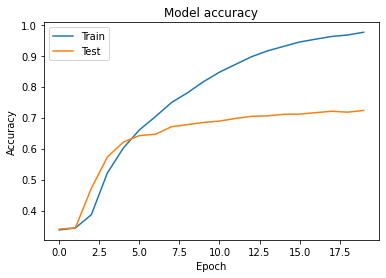

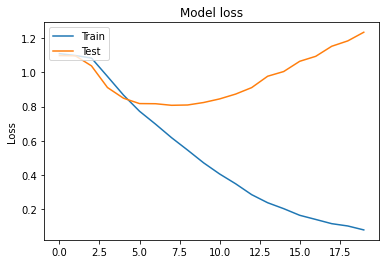


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


12/12 [==============================] - 17s 1s/step

Inferencing
6/6 [==============================] - 5s 809ms/step

Fold 2 Accuracy: 0.723


CV Mean Accuracy: 0.7183
CV StdDev Accuracy: 0.0047



0    2027
2    1617
1    1551
Name: prediction, dtype: int64

In [ ]:
# Model: Distilbert Base Uncased
config_7 = Configuration("distilbert-base-uncased", "distilbert_base_uncased.h5", max_length = 250, batch_size = 32, epochs = 20, train_splits = 2)
preds_train_7, preds_test_7 = run_model(config_7)
df_test = pd.read_csv("/content/drive/MyDrive/nlp/data/translated/english_transled_test.csv")
df_submission = pd.DataFrame({"id": df_test.id.values, "prediction": np.argmax(preds_test_7, axis = 1)})
df_submission.to_csv("/content/drive/MyDrive/nlp/data/translated/Distilbert_Base_Uncased.csv", index = False)
df_submission.prediction.value_counts()